# PINNs
Using it to improve physical models.  
  
We are using it now on a toy problem. For more details on the physics of the problem:
https://youtu.be/AXXnSzmpyoI

In [45]:
# Importing all the necessary libraries
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split
from helper_functions import plot3D, plot3D_Matrix

import numpy as np
import time
from pyDOE import lhs                               # Latin Hypercube Sampling
import scipy.io

torch.set_default_dtype(torch.float)

# Setting up reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

### Generating and Visualising the Data

Shape of X:torch.Size([200, 100]), Shape of T:torch.Size([200, 100])


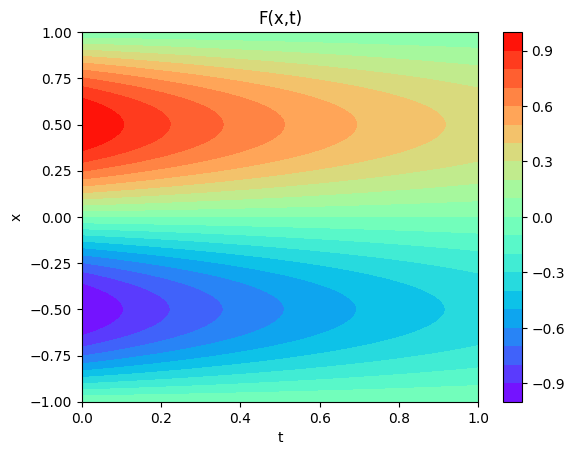

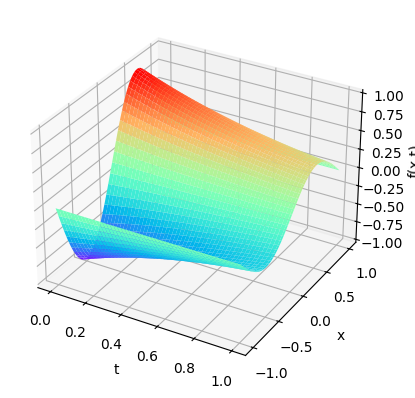

In [46]:
def y_exact(x, t):
    """Gives the exact solutions for the differential equation"""
    return torch.exp(-t)*torch.sin(np.pi * x)

# Generating the data
x = torch.linspace(-1, 1, 200)
t = torch.linspace(0, 1, 100)

X, T = torch.meshgrid(x, t)
print(f"Shape of X:{X.shape}, Shape of T:{T.shape}")

# This basically prints out ALL POSSIBLE values of y_exact for all permutations of x and t
y_val = y_exact(X, T)
plot3D(x, t, y_val)

In [47]:
# Testing data
X_test = torch.hstack((X.transpose(1, 0).flatten()[:, None], T.transpose(1, 0).flatten()[:, None]))
y_test = y_val.transpose(1, 0).flatten()[:, None]

lower_bound = X_test[0]
upper_bound = X_test[-1]

lower_bound

tensor([-1.,  0.])

In [48]:
# Training data

# Setting up the initial condition
# y(x, 0) = sin(pi*x)
initial_condition_X = torch.hstack((X[:,0][:,None],T[:,0][:, None]))
initial_condition_y = torch.sin(np.pi*initial_condition_X[:,0]).unsqueeze(dim=1)

# Setting up the boundary conditions
# y(-1, t) = 0
# y(1, t) = 0
boundary_condition_1_X = torch.hstack((X[0,:][:,None],T[0,:][:, None]))
boundary_condition_1_y = torch.zeros(200, 1)

boundary_condition_2_X = torch.hstack((X[-1,:][:,None],T[-1,:][:, None]))
boundary_condition_2_y = torch.zeros(200, 1)

#initial_condition_X.shape, boundary_condition_1_X.shape, boundary_condition_2_X.shape
X_train = torch.vstack([initial_condition_X, boundary_condition_1_X, boundary_condition_2_X])
y_train = torch.vstack([initial_condition_y, boundary_condition_1_y, boundary_condition_2_y])


In [49]:
# Now to random sample the data
Nu = 100
index = np.random.choice(X_train.shape[0], Nu, replace=False)

X_train_Nu = X_train[index]
y_train_Nu = y_train[index]

X_train_Nu = X_train_Nu.type(torch.float).to(device)
y_train_Nu = y_train_Nu.type(torch.float).to(device)

In [50]:
# Collocation points
Nf = 10000

X_train_Nf = lower_bound + ((upper_bound - lower_bound) * lhs(2, Nf))
X_train_Nf = X_train_Nf.type(torch.float).to(device)

X_train_Nf = torch.vstack((X_train_Nu, X_train_Nf))

f_hat = torch.zeros(X_train_Nf.shape[0], 1).to(device)

/tmp/ipykernel_9265/388533571.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  X_train_Nf = lower_bound + ((upper_bound - lower_bound) * lhs(2, Nf))


In [51]:
# Model

class PhysicsInformedNN(nn.Module):
    def __init__(self, layers: list):
        super().__init__()
        self.network = nn.ModuleList()
        
        self.activation = nn.Tanh()
        self.loss = nn.MSELoss(reduction='mean')
        
        for layer_num in range(len(layers)-1):
            self.network.append(nn.Linear(in_features=layers[layer_num], out_features=layers[layer_num+1]))
        
        """
        This loop:
            -Iterates over every linear layer in your neural network
            -Initializes:
                + Weights → Xavier Normal distribution
                + Biases → Zeros
        """
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.network[i].weight.data, gain=1.0)
            nn.init.zeros_(self.network[i].bias.data)
            
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, 
                                          amsgrad=True)# weight_decay=1e-6)
            
    def forward(self, x):
        out = x
        for layer in range(len(self.network)-1):
            out = self.activation(self.network[layer](out))

        return self.network[-1](out)
    
    def lossBC(self, x, y):
        return self.loss(self.forward(x), y)
    
    def lossPDE(self, x_pde, zero_mat):
        g = x_pde.clone()
        g.requires_grad = True
        
        NN = self.forward(g)
        NN_x_t = autograd.grad(NN, g, torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        NN_xx_tt = autograd.grad(NN_x_t, g, torch.ones(g.shape).to(device), create_graph=True)[0]
        
        NN_t = NN_x_t[:, [1]]
        NN_xx = NN_xx_tt[:, [0]]
        
        f = (NN_t - NN_xx) + torch.exp(-g[:, [1]])*(torch.sin(np.pi*g[:, [0]]) - ((np.pi**2)*torch.sin(np.pi*g[:, [0]])))
        return self.loss(f, zero_mat)
    
    def net_loss(self, x, y, x_pde, zero_mat, l2_lambda=1e-6) -> list:
        BCLoss = self.lossBC(x, y)
        PDELoss = self.lossPDE(x_pde, zero_mat)
        
        l2 = 0.0
        for p in self.parameters():
            l2 += torch.sum(p**2)
            
        return [BCLoss + PDELoss + (l2_lambda*l2), BCLoss, PDELoss]

In [52]:
# Training
layer_list = [2, 64, 64, 1]
PiNN = PhysicsInformedNN(layer_list).to(device)

PiNN

PhysicsInformedNN(
  (network): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (activation): Tanh()
  (loss): MSELoss()
)

In [53]:
epochs = 12500
epoch_list, loss_list, test_loss_list = [], [], []
BC_train_loss, PDE_train_loss = [], []

torch.manual_seed(32)
torch.cuda.manual_seed(32)

for epoch in range(epochs):
    PiNN.train()

    # Forward pass already done in the loss functions
    # Loss
    loss_info = PiNN.net_loss(X_train_Nu, y_train_Nu, X_train_Nf, f_hat)
    loss = loss_info[0]
    
    # Optimizer
    PiNN.optimizer.zero_grad()
    loss.backward()
    PiNN.optimizer.step()
    
    if epoch % 500 == 0:
        PiNN.eval()
        with torch.inference_mode():
            test_loss = PiNN.lossBC(X_test.to(device), y_test.to(device))
            
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Test Loss: {test_loss:.5f}")
        epoch_list.append(epoch)
        loss_list.append(loss.cpu().detach().numpy())
        test_loss_list.append(test_loss.cpu().detach().numpy())
        BC_train_loss.append(loss_info[1].cpu().detach().numpy())
        PDE_train_loss.append(loss_info[2].cpu().detach().numpy())
        #test_BC_loss_list.append(test_loss_info[1].cpu().detach().numpy())
        #test_PDE_loss_list.append(test_loss_info[2].cpu().detach().numpy())


Epoch: 0, Loss: 17.15790, Test Loss: 0.20161
Epoch: 500, Loss: 3.11976, Test Loss: 0.06022
Epoch: 1000, Loss: 0.95940, Test Loss: 0.01489
Epoch: 1500, Loss: 0.44179, Test Loss: 0.01483
Epoch: 2000, Loss: 0.28947, Test Loss: 0.02241
Epoch: 2500, Loss: 0.21282, Test Loss: 0.02462
Epoch: 3000, Loss: 0.14055, Test Loss: 0.02697
Epoch: 3500, Loss: 0.08851, Test Loss: 0.03139
Epoch: 4000, Loss: 0.06349, Test Loss: 0.03543
Epoch: 4500, Loss: 0.05230, Test Loss: 0.03817
Epoch: 5000, Loss: 0.04570, Test Loss: 0.03978
Epoch: 5500, Loss: 0.04060, Test Loss: 0.04066
Epoch: 6000, Loss: 0.03629, Test Loss: 0.04102
Epoch: 6500, Loss: 0.03264, Test Loss: 0.04091
Epoch: 7000, Loss: 0.02957, Test Loss: 0.04038
Epoch: 7500, Loss: 0.02695, Test Loss: 0.03947
Epoch: 8000, Loss: 0.02466, Test Loss: 0.03827
Epoch: 8500, Loss: 0.02259, Test Loss: 0.03687
Epoch: 9000, Loss: 0.02065, Test Loss: 0.03536
Epoch: 9500, Loss: 0.01883, Test Loss: 0.03385
Epoch: 10000, Loss: 0.01710, Test Loss: 0.03243
Epoch: 10500, L

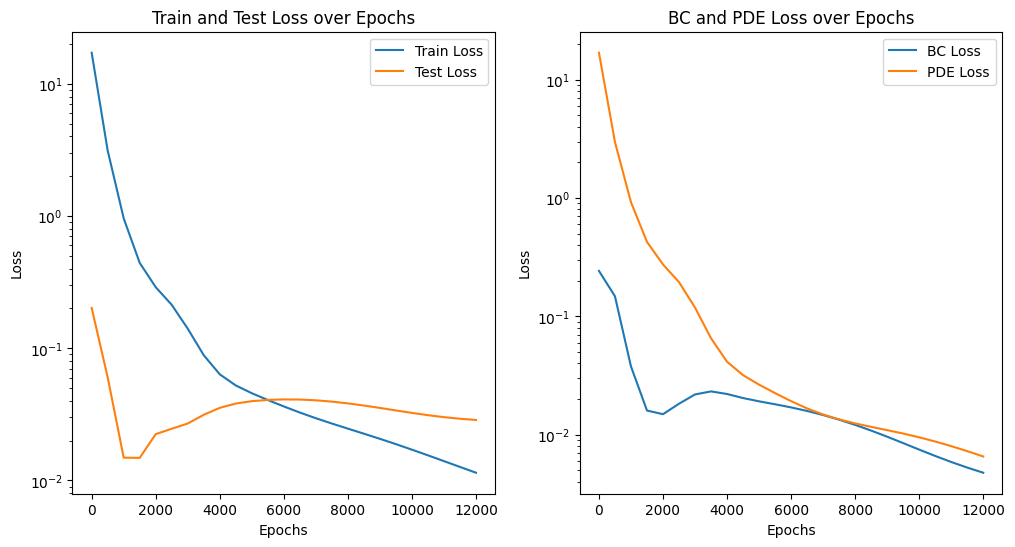

In [54]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_list, loss_list, label="Train Loss")
plt.plot(epoch_list, test_loss_list, label="Test Loss")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss over Epochs")
plt.legend()

plt.subplot(1, 2 ,2)
plt.plot(epoch_list, BC_train_loss, label="BC Loss")
plt.plot(epoch_list, PDE_train_loss, label="PDE Loss")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("BC and PDE Loss over Epochs")
plt.legend()

plt.show()
plt.close('all')

### TO-DO
- Adjust the regularization in the loss function rather than in the optimizer
- Try L1, L2
- (Add more networks??)

In [56]:
y1 = PiNN.forward(X_test.to(device))
x1 = X_test[:,0]
t1 = X_test[:,1]

In [58]:
arr_x1 = x1.reshape(shape=[100,200]).transpose(1,0).cpu().detach()
arr_T1 = t1.reshape(shape=[100,200]).transpose(1,0).cpu().detach()
arr_y1 = y1.reshape(shape=[100,200]).transpose(1,0).cpu().detach()

arr_y_test = y_test.reshape(shape=[100,200]).transpose(1,0).cpu().detach()

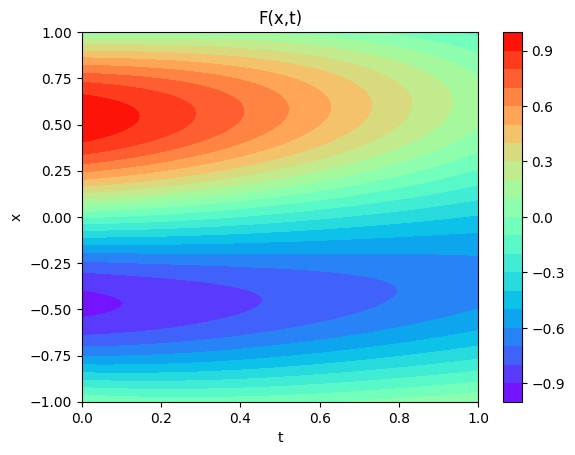

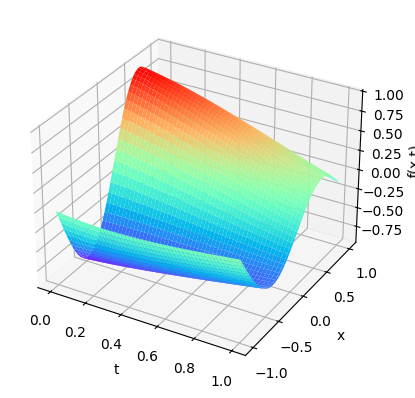

In [59]:
plot3D_Matrix(arr_x1, arr_T1, arr_y1)